In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex, Markdown
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os
import json
import pandas as pd

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, DDR_f, DDC_f, DDP_r_f
from masa_utils_pytorch import Optimization, TorchHelper

# Basic concets of frequency range and time constant range

In [4]:
# set frequency range
freq_strt_log = 0
freq_end_log = 4
freq_step_log = 0.01
freq = 10**np.arange(freq_strt_log, freq_end_log+freq_step_log, freq_step_log)
freq_strt = 10**(freq_strt_log+1)
print(freq)

[1.00000000e+00 1.02329299e+00 1.04712855e+00 1.07151931e+00
 1.09647820e+00 1.12201845e+00 1.14815362e+00 1.17489755e+00
 1.20226443e+00 1.23026877e+00 1.25892541e+00 1.28824955e+00
 1.31825674e+00 1.34896288e+00 1.38038426e+00 1.41253754e+00
 1.44543977e+00 1.47910839e+00 1.51356125e+00 1.54881662e+00
 1.58489319e+00 1.62181010e+00 1.65958691e+00 1.69824365e+00
 1.73780083e+00 1.77827941e+00 1.81970086e+00 1.86208714e+00
 1.90546072e+00 1.94984460e+00 1.99526231e+00 2.04173794e+00
 2.08929613e+00 2.13796209e+00 2.18776162e+00 2.23872114e+00
 2.29086765e+00 2.34422882e+00 2.39883292e+00 2.45470892e+00
 2.51188643e+00 2.57039578e+00 2.63026799e+00 2.69153480e+00
 2.75422870e+00 2.81838293e+00 2.88403150e+00 2.95120923e+00
 3.01995172e+00 3.09029543e+00 3.16227766e+00 3.23593657e+00
 3.31131121e+00 3.38844156e+00 3.46736850e+00 3.54813389e+00
 3.63078055e+00 3.71535229e+00 3.80189396e+00 3.89045145e+00
 3.98107171e+00 4.07380278e+00 4.16869383e+00 4.26579519e+00
 4.36515832e+00 4.466835

# $\tau_\rho 2 \pi f =1 $

In [5]:
# set the range of time constant
taus_log_1 = -np.log10(2*np.pi) - freq_strt_log -1.0
taus_log_2 = -np.log10(2*np.pi) - freq_strt_log 
taus_1 = 10.**taus_log_1
taus_2 = 10.**taus_log_2

print(taus_1)
print(taus_2)
taus = np.r_[taus_1, taus_2]

0.015915494309189537
0.15915494309189535


In [6]:
ip_model = DDR_f(freq=freq, taus=taus, con=False)
# ip_model = DDP_r_f(freq=freq, taus=taus, con=False)
ip_model.show_equation()




### Debye Decomposition Resistivity Model in frequency domain
$$
\rho(\omega)=\rho_0 \left[1-\sum_{j=1}^n \eta_j \left(1- \dfrac{1}{1+i\omega\tau_j}\right)\right]
$$

- $\rho_0$: Resistivity at low frequency ($\Omega\,$m)
- $\eta_j$: Chargeabilities (dimensionless)  
- $\tau_j$: Time constants (s)  
- $n$: Total number of relaxation


In [7]:
etas=np.r_[0.5]
model_0 = TorchHelper.to_tensor_r(np.r_[np.log(2.0),np.r_[0.5,0]])
model_1 = TorchHelper.to_tensor_r(np.r_[np.log(2.0),np.r_[0.0,0.5]])
model_2 = TorchHelper.to_tensor_r(np.r_[np.log(1.0),np.r_[0,0]])
nmodel = 3
models = [model_0, model_1, model_2]

In [8]:
dpreds = []

dpreds.append(ip_model.f(models[0]).detach().numpy())
dpreds.append(ip_model.f(models[1]).detach().numpy())
dpreds.append(ip_model.f(models[2]).detach().numpy())

In [9]:
def plot_sip(freq, dpreds, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(5,3))
    nfreq = len(freq)

    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)

    # sip_real = dpreds.real
    # sip_imag = dpreds.imag
    sip_abs = np.abs(dpreds)
    sip_phs = np.angle(dpreds, deg=True)
    ax[0].semilogx(freq, sip_abs, **default_kwargs)
    ax[1].semilogx(freq, sip_phs, **default_kwargs)

    ax[0].set_ylim(bottom=0)
    ax[0].set_title(f"SIP in Absolute Value")
    ax[0].set_ylabel("[Ohm.m]")
    ax[1].set_title(f"SIP in Phase [deg]")
    ax[1].set_ylabel("[deg]")

    for a in ax:
        a.set_xlabel("[Hz]")

    return ax

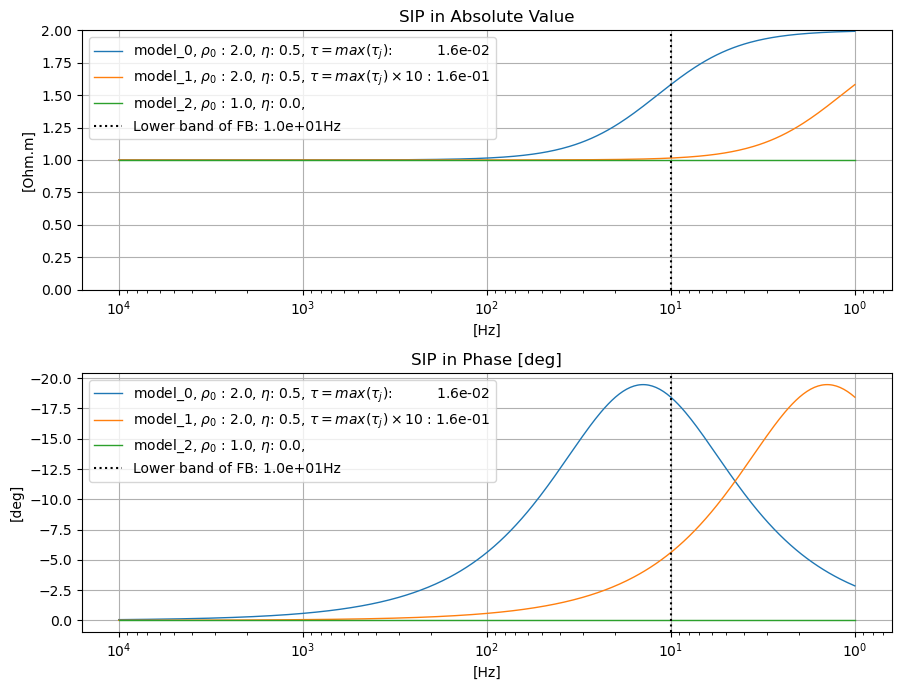

In [12]:
# labels = [fr"$\rho_0$ : 1.0, $\eta$: 0.0,",
#           fr"$\rho_0$ : 2.0, $\eta$: 0.5, $\tau$: {taus_1:.1e}",
#           fr"$\rho_0$ : 2.0, $\eta$: 0.5, $\tau$: {taus_2:.1e}"]

labels = [fr"model_0, $\rho_0$ : 2.0, $\eta$: 0.5, $\tau=max(\tau_j)$:          {taus_1:.1e}",
          fr"model_1, $\rho_0$ : 2.0, $\eta$: 0.5, $\tau=max(\tau_j)\times 10$ : {taus_2:.1e}",
          fr"model_2, $\rho_0$ : 1.0, $\eta$: 0.0,"]
fig, ax = plt.subplots(2, 1, figsize=(9,7))

ax = plot_sip(freq, dpreds[0],ax=ax, color="C0", label=labels[0])
ax = plot_sip(freq, dpreds[1],ax=ax, color="C1", label=labels[1], linestyle="-")
ax = plot_sip(freq, dpreds[2],ax=ax, color="C2", label=labels[2], linestyle="-")
for a in ax:
    a.grid()
    a.invert_xaxis()
    a.axvline(x=freq_strt, color="k", linestyle=":", label=f"Lower band of FB: {freq_strt:.1e}Hz")
    a.legend()
ax[1].invert_yaxis()
ax[0].set_ylim(0, 2)
plt.tight_layout()
plt.savefig("41_big_tau.jpg", dpi=300)